In [72]:
import warnings
warnings.filterwarnings("ignore")

In [73]:
# Instalar las librerías necesarias
%pip install requests
%pip install kneed


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [74]:
# Importar librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
import requests
from io import StringIO



# Lectura del dataset
Utilizaremos el conjunto de datos de calidad del vino. Este conjunto de datos contiene varias propiedades químicas del vino, como la acidez, el azúcar, el pH y el alcohol. También contiene una métrica de calidad (3-9, siendo mejor la más alta) y un color (rojo o blanco).

In [75]:
# URL del archivo CSV en GitHub
url = 'https://raw.githubusercontent.com/osiris-contreras/Osiris-Contreras-Trillos-/main/Wine_Quality_Data.csv'

# Obtener los datos del archivo CSV
response = requests.get(url)
csv_data = response.content.decode('utf-8')

# Leer los datos del archivo CSV utilizando pandas
df = pd.read_csv(StringIO(csv_data))

# Mostrar las primeras filas del DataFrame
df.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality color  
0      9.4        5   red  
1      9.8        5   red  
2      9.8        5   red  
3      9.8        6   red  
4      9.4        5   red

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [77]:
df.describe()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            17.000000             77.000000     0.992340   
50%       0.047000            29.000000            118.000000     0.994890   
75%       0.065000            41.000000            156.000000     0.996990   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  
count  6497.000000  6497.000000  6497.000000  6497.000000  
mean      3.218501     0.531268    10.491801     5.818378  
std       0.160787     0.148806     1.192712     0.873255  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.110000     0.430000     9.500000     5.000000  
50%       3.210000     0.510000    10.300000     6.000000  
75%       3.320000     0.600000    11.300000     6.000000  
max       4.010000     2.000000    14.900000     9.000000

In [78]:
# Descripción estadística general de las variables categóricas
df.describe(include=['object'])

color
count    6497
unique      2
top     white
freq     4898

In [79]:
# Comprobación de valores duplicados
df.duplicated().sum()

1177

In [80]:
# Eliminación de valores duplicados
df2 = df.drop_duplicates()

# Comprobación de valores duplicados
df2.duplicated().sum()
df2.shape

(5320, 13)

In [81]:
# Descripción estadística general de las variables categóricas
df2.describe(include=['object'])

color
count    5320
unique      2
top     white
freq     3961

In [82]:
float_columns = [x for x in df2.columns if x not in ['color', 'quality']]

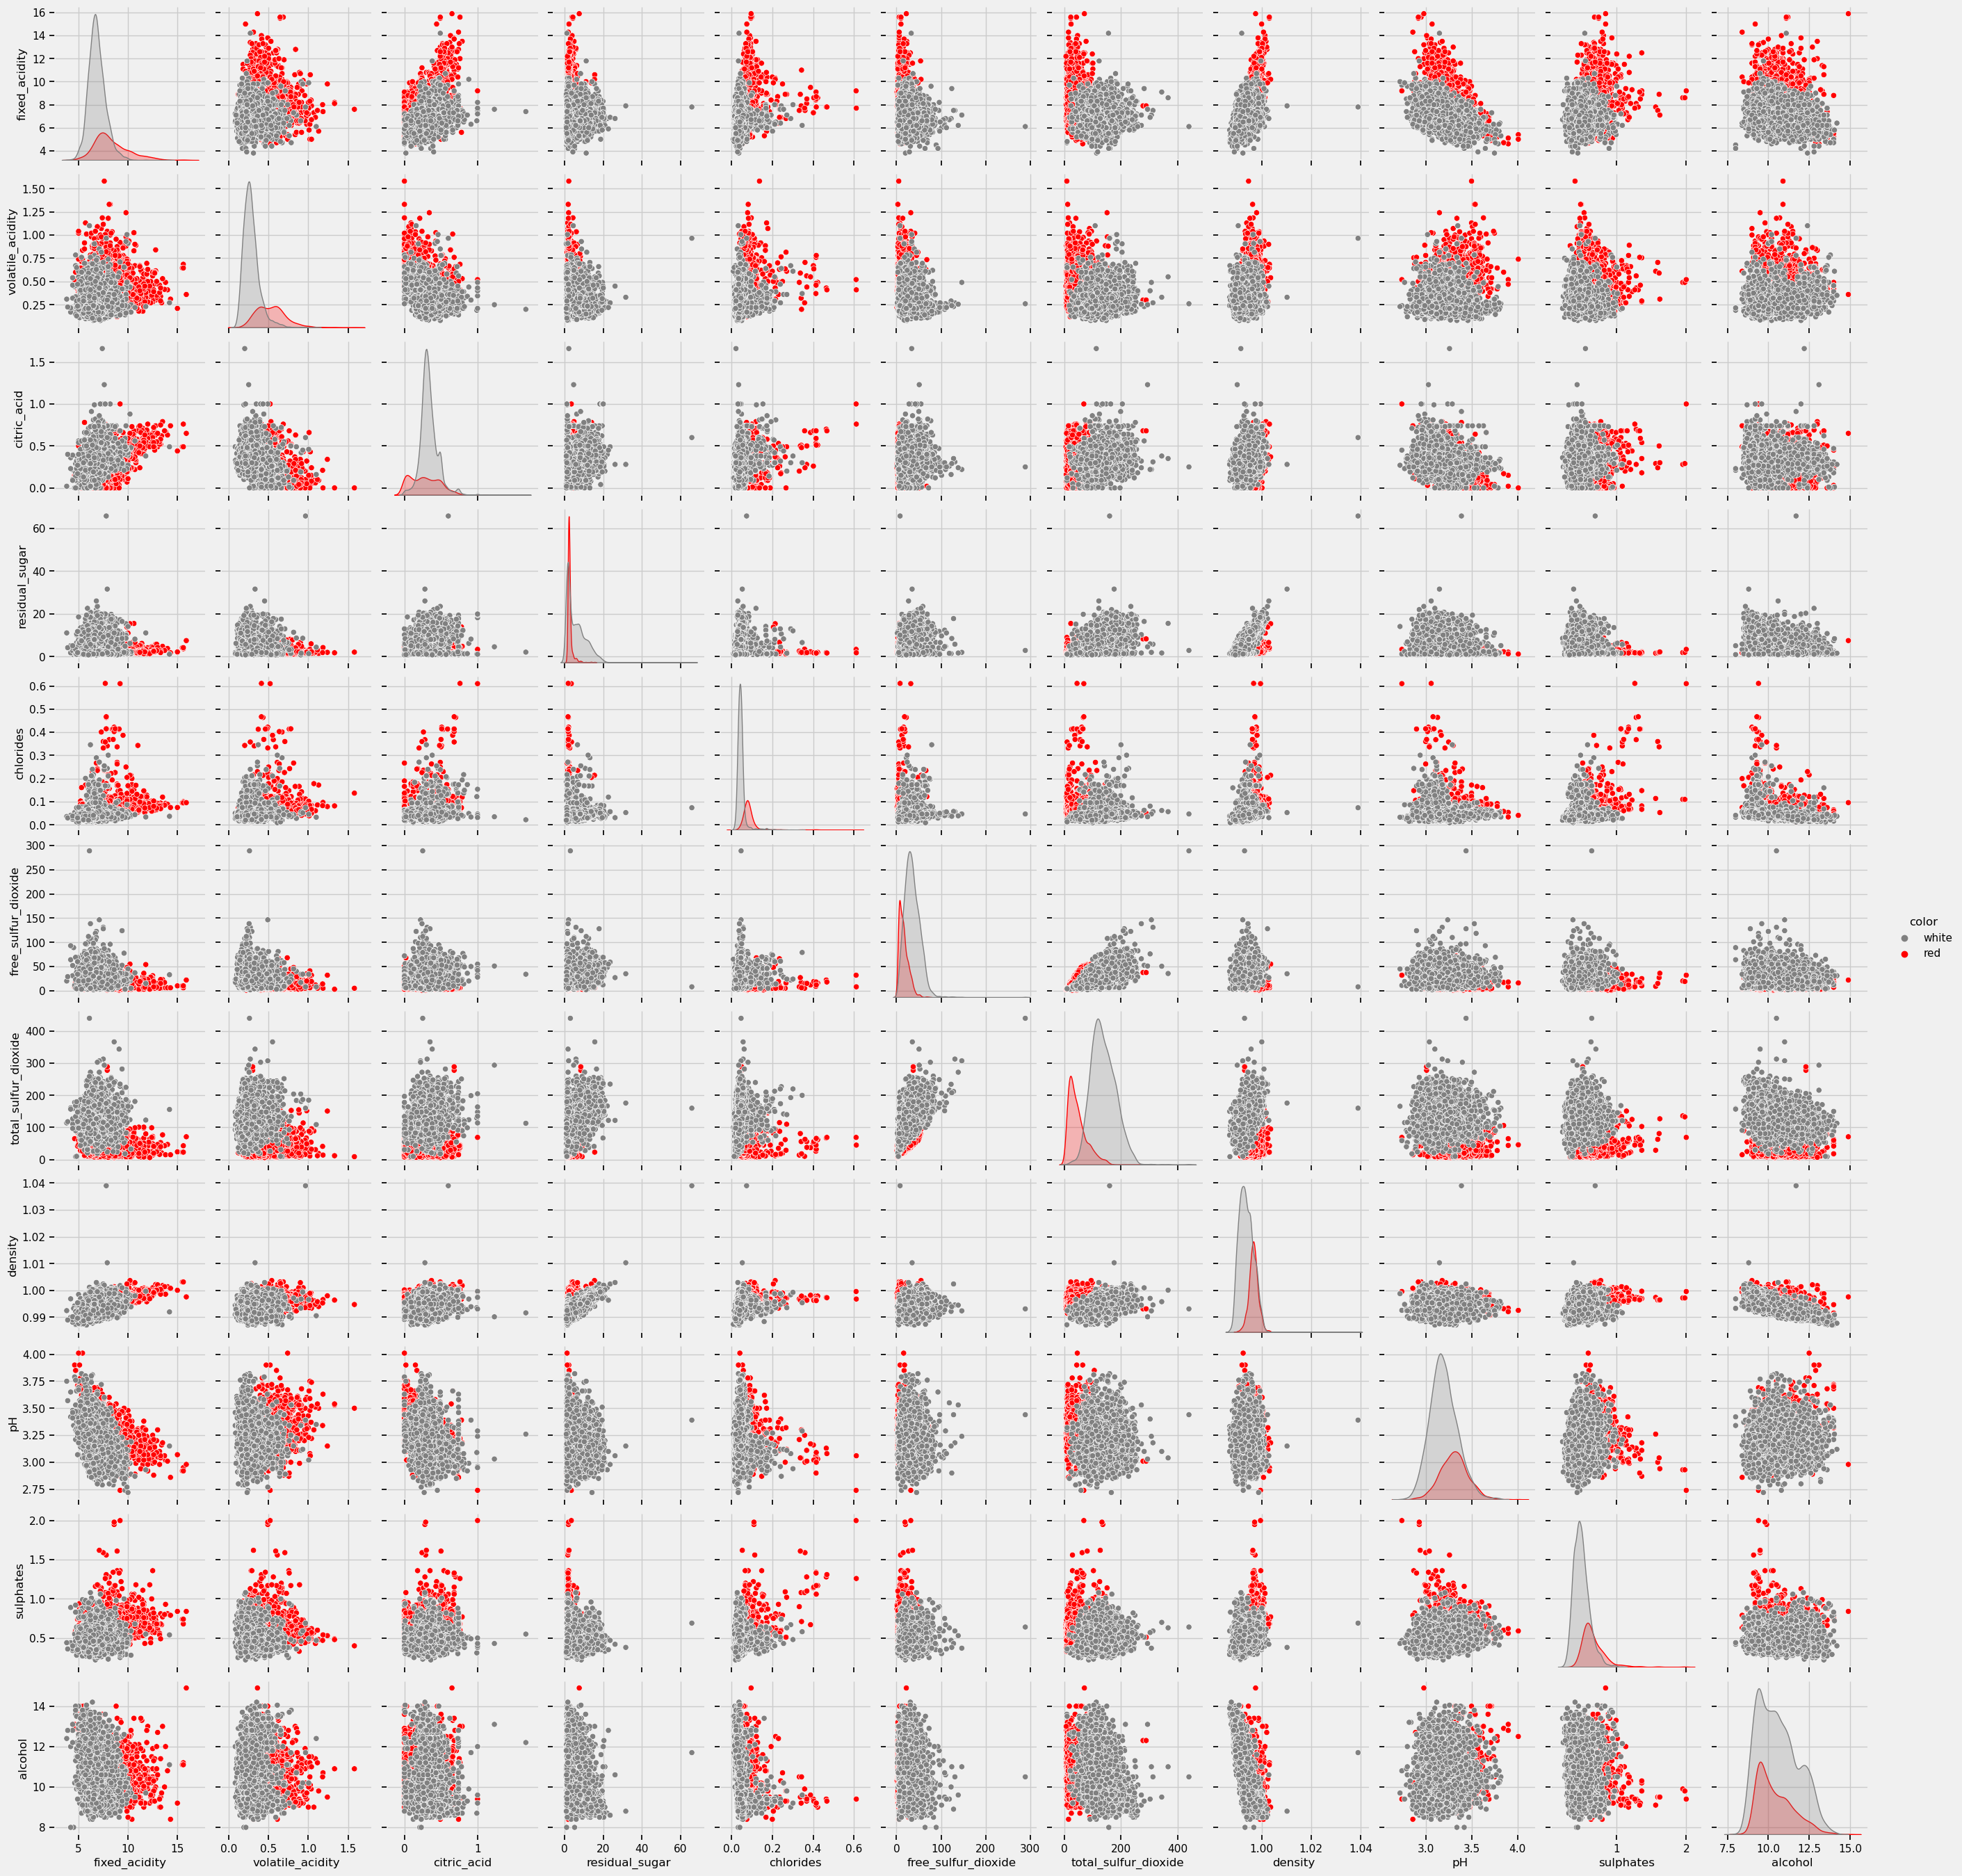

In [83]:
temp = df2[float_columns + ['color']]

sns.set_context('notebook')
sns.pairplot(temp, 
             hue='color', 
             hue_order=['white', 'red'],
             palette={'red':'red', 'white':'gray'});

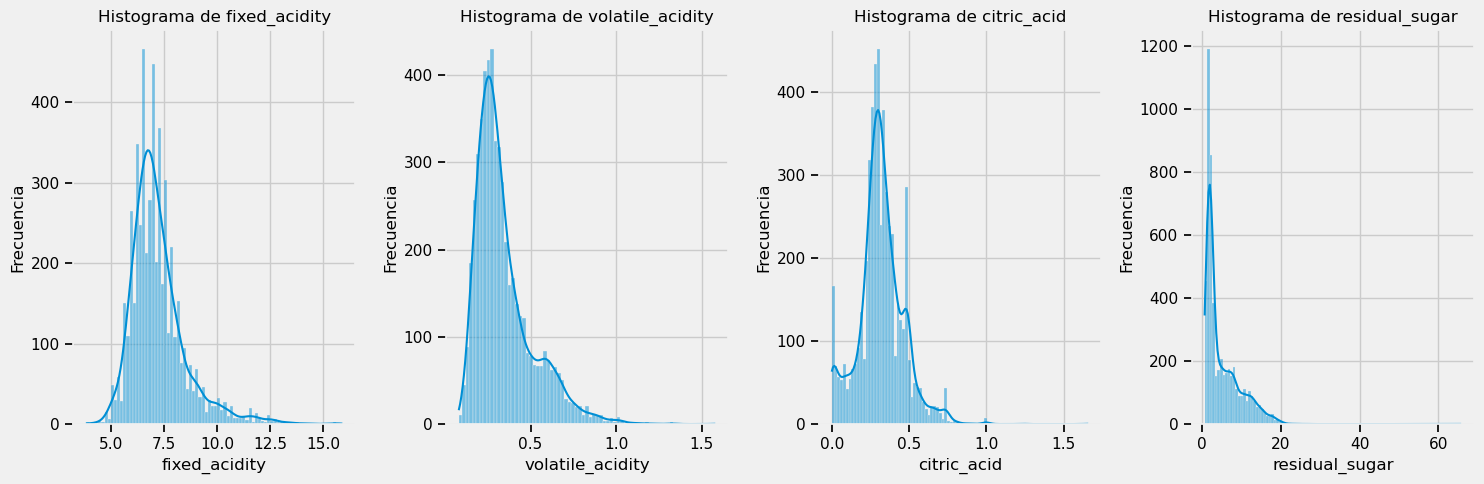

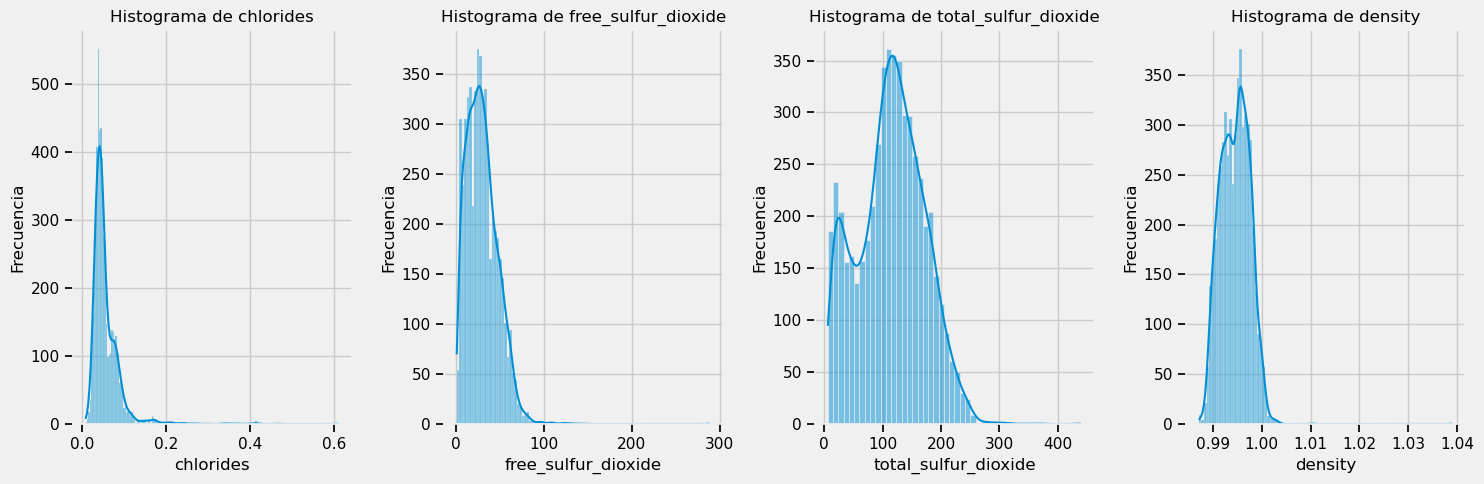

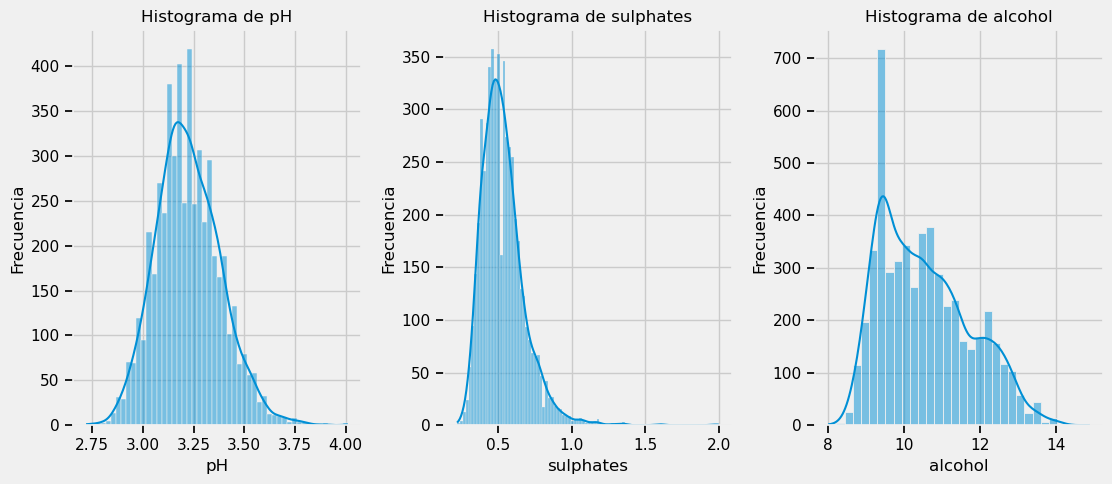

In [84]:
# Configurar el número de columnas en la disposición de subplots
num_columnas = 4

# Histogramas para variables numéricas
for i, num_var in enumerate(float_columns):
    if i % num_columnas == 0:
        plt.figure(figsize=(15, 5))
    plt.subplot(1, num_columnas, i % num_columnas + 1)
    sns.histplot(df2[num_var], kde=True)
    plt.title(f'Histograma de {num_var}')
    plt.xlabel(num_var)
    plt.ylabel('Frecuencia')
    if (i + 1) % num_columnas == 0 or i == len(float_columns) - 1:
        plt.tight_layout()
        plt.show()

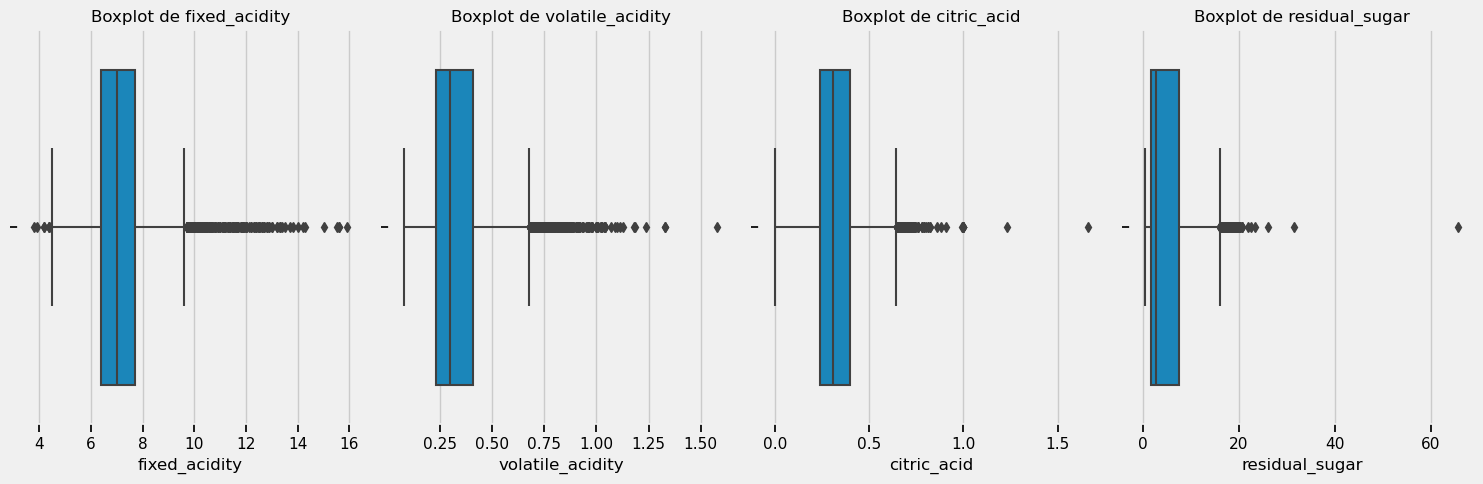

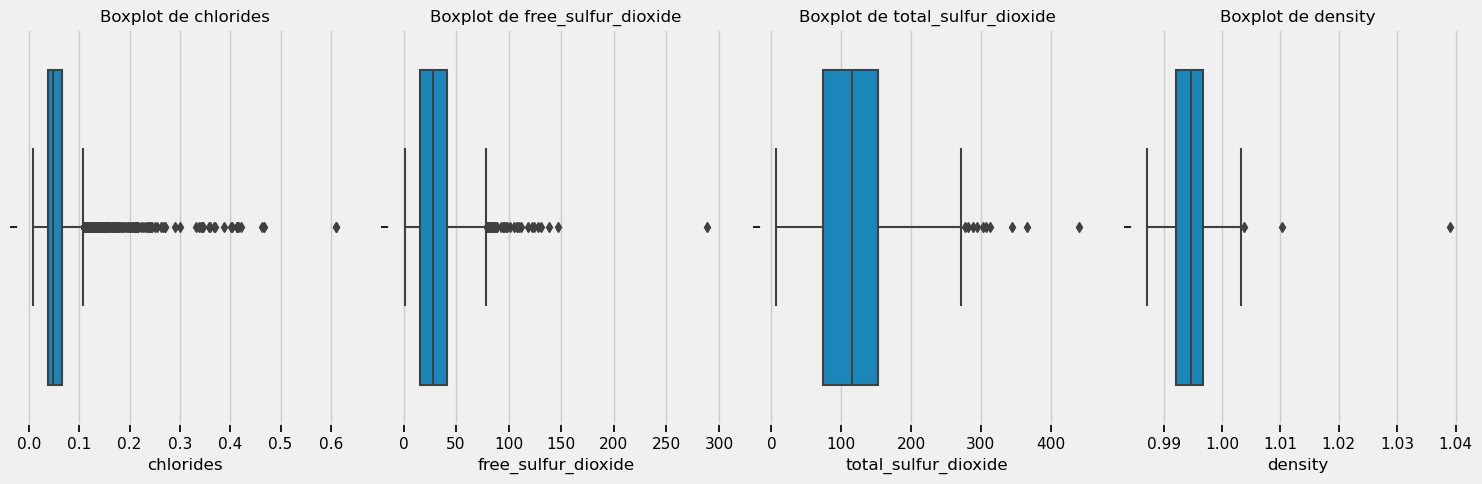

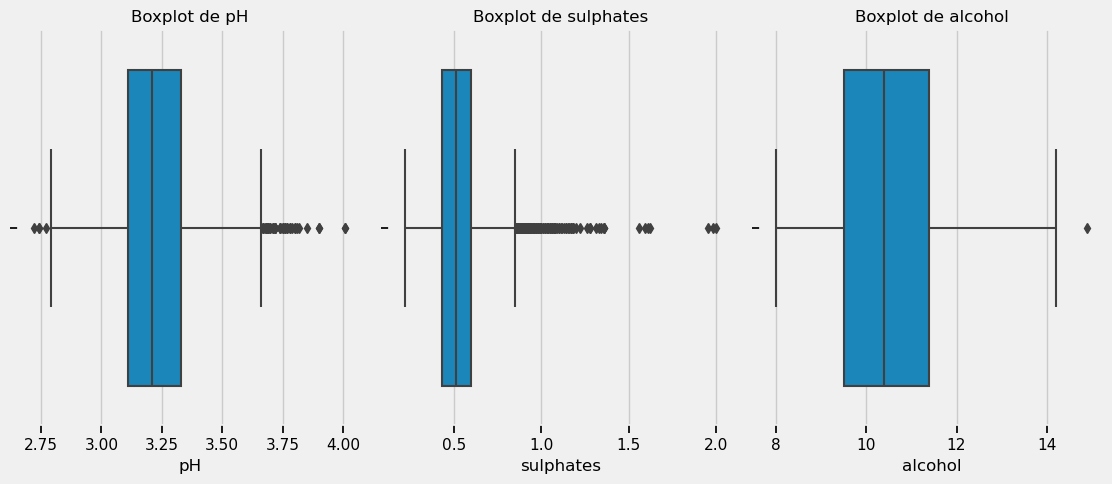

In [85]:
# Boxplots para variables numéricas
for i, num_var in enumerate(float_columns):
    if i % num_columnas == 0:
        plt.figure(figsize=(15, 5))
    plt.subplot(1, num_columnas, i % num_columnas + 1)
    sns.boxplot(x=df2[num_var])
    plt.title(f'Boxplot de {num_var}')
    plt.xlabel(num_var)
    if (i + 1) % num_columnas == 0 or i == len(float_columns) - 1:
        plt.tight_layout()
        plt.show()

## Tratamiento de valores atípicos cuantiless

In [86]:
# Crear una copia del DataFrame original
df3 = df2.copy()

# Identificar y manejar outliers en cada columna numérica
for column in df3.columns:
    if df3[column].dtype != 'object':  # Solo trabajamos con columnas numéricas
        q1 = df3[column].quantile(0.25)
        q3 = df3[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Reemplazar los valores atípicos por los límites del rango intercuartílico
        df3[column] = df3[column].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

In [87]:
df3.shape

(5320, 13)

In [88]:
# Descripción estadística general de las variables categóricas
df3.describe(include=['object'])

color
count    5320
unique      2
top     white
freq     3961

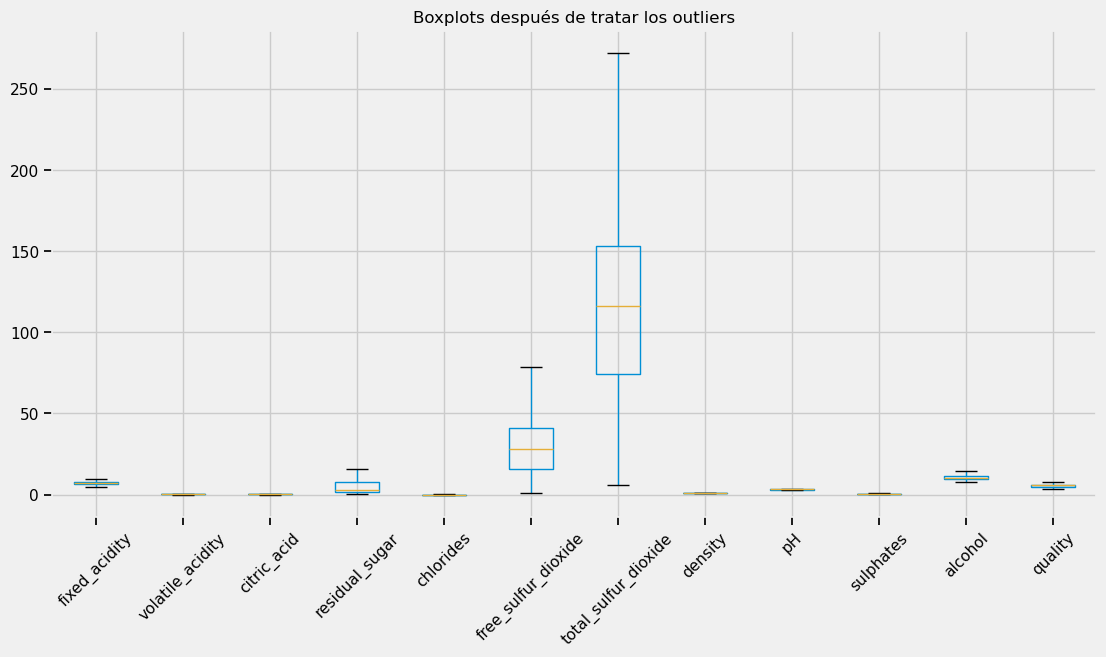

In [89]:
# Crear boxplots para cada columna numérica en df3 (después de tratar los outliers)
plt.figure(figsize=(12, 6))
df3.boxplot()
plt.title('Boxplots después de tratar los outliers')
plt.xticks(rotation=45)
plt.show()

## tratamiento de atípicos Winsorized

In [90]:
# Crear una copia del DataFrame original
df_winsorized = df2.copy()

# Seleccionar las columnas numéricas
numeric_columns = df_winsorized.select_dtypes(include=np.number).columns

# Aplicar la winsorización a cada columna numérica
for column in numeric_columns:
    # Calcular los percentiles 5 y 95
    p5 = np.percentile(df_winsorized[column], 5)
    p95 = np.percentile(df_winsorized[column], 95)
    # Reemplazar los valores atípicos con los valores correspondientes a los percentiles 5 y 95
    df_winsorized[column] = np.where(df_winsorized[column] < p5, p5, df_winsorized[column])
    df_winsorized[column] = np.where(df_winsorized[column] > p95, p95, df_winsorized[column])

# Mostrar las primeras filas del DataFrame winsorizado
df_winsorized.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.68         0.04             1.9      0.076   
1            7.8              0.68         0.04             2.6      0.098   
2            7.8              0.68         0.04             2.3      0.092   
3            9.8              0.28         0.56             1.9      0.075   
5            7.4              0.66         0.04             1.8      0.075   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.50       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
5                 13.0                  40.0   0.9978  3.50       0.56   

   alcohol  quality color  
0      9.4      5.0   red  
1      9.8      5.0   red  
2      9.8      5.0   red  
3      9.8      6.0   red  
5      9.4      5.0   red

In [91]:
df_winsorized.shape

(5320, 13)

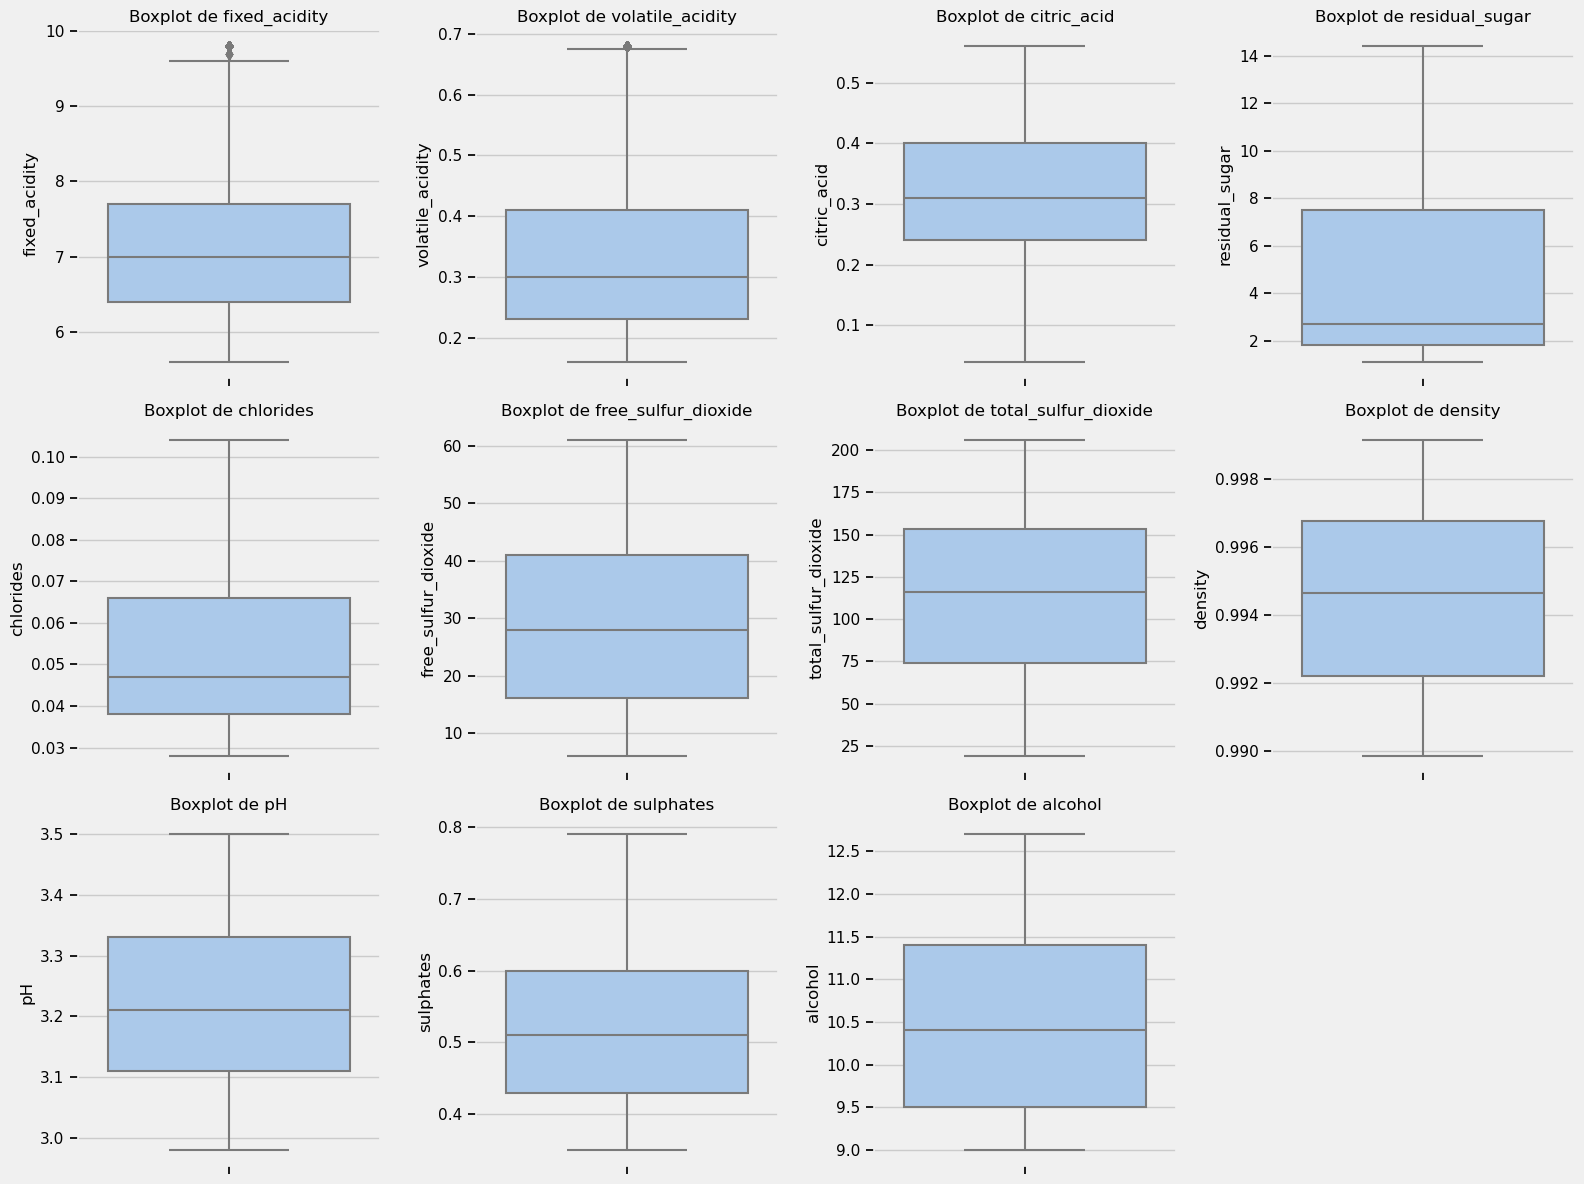

In [92]:
# Boxplots horizontales separados para cada variable en el DataFrame winsorizado
num_variables = df_winsorized.drop(columns=['color', 'quality']).shape[1]
num_cols = min(num_variables, 4)  # Máximo 4 columnas
num_rows = (num_variables + num_cols - 1) // num_cols  # Calcular número de filas

plt.figure(figsize=(num_cols * 4, num_rows * 4))
for i, column in enumerate(df_winsorized.drop(columns=['color', 'quality']).columns):
    plt.subplot(num_rows, num_cols, i+1)
    sns.boxplot(y=df_winsorized[column], palette='pastel')
    plt.title(f'Boxplot de {column}')
    plt.tight_layout()

plt.show()

## reemplazo de las observaciones red and white por las proporciones 

In [93]:
# Calcular la proporción de cada categoría en la columna 'color'
color_proportions = df3['color'].value_counts(normalize=True)

# Renombrar la variable 'color' por la proporción respectiva en el conjunto de datos
df3['color'] = df3['color'].map(color_proportions)

# Mostrar las primeras filas del DataFrame con la variable 'color' renombrada
df3.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0           7.40              0.68         0.00             1.9      0.076   
1           7.80              0.68         0.00             2.6      0.098   
2           7.80              0.68         0.04             2.3      0.092   
3           9.65              0.28         0.56             1.9      0.075   
5           7.40              0.66         0.00             1.8      0.075   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
5                 13.0                  40.0   0.9978  3.51       0.56   

   alcohol  quality     color  
0      9.4      5.0  0.255451  
1      9.8      5.0  0.255451  
2      9.8      5.0  0.255451  
3      9.8      6.0  0.255451  
5      9.4      5.0  0.255451

In [94]:
# Calcular la proporción de cada categoría en la columna 'color'
color_proportions = df_winsorized['color'].value_counts(normalize=True)

# Renombrar la variable 'color' por la proporción respectiva en el conjunto de datos
df_winsorized['color'] = df_winsorized['color'].map(color_proportions)

# Mostrar las primeras filas del DataFrame con la variable 'color' renombrada
df_winsorized.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.68         0.04             1.9      0.076   
1            7.8              0.68         0.04             2.6      0.098   
2            7.8              0.68         0.04             2.3      0.092   
3            9.8              0.28         0.56             1.9      0.075   
5            7.4              0.66         0.04             1.8      0.075   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.50       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
5                 13.0                  40.0   0.9978  3.50       0.56   

   alcohol  quality     color  
0      9.4      5.0  0.255451  
1      9.8      5.0  0.255451  
2      9.8      5.0  0.255451  
3      9.8      6.0  0.255451  
5      9.4      5.0  0.255451

In [95]:
# Scaling data 
scaler = StandardScaler()
scaler.fit(df3)
scaled1 = pd.DataFrame(scaler.transform(df3),columns = df3.columns)

# Scaled data
scaled1.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0       0.238055          2.298926    -2.273272       -0.724004   1.019157   
1       0.605077          2.298926    -2.273272       -0.559650   2.020762   
2       0.605077          2.298926    -1.985367       -0.630087   1.747597   
3       2.302554         -0.386644     1.757397       -0.724004   0.973630   
4       0.238055          2.164647    -2.273272       -0.747483   0.973630   

   free_sulfur_dioxide  total_sulfur_dioxide   density        pH  sulphates  \
0            -1.114479             -1.417952  1.128801  1.812423   0.240980   
1            -0.287116             -0.833163  0.783878 -0.151665   1.156786   
2            -0.878090             -1.063534  0.852863  0.228481   0.927835   
3            -0.759895             -0.957209  1.197786 -0.405096   0.393614   
4            -0.996285             -1.311627  1.128801  1.812423   0.240980   

    alcohol   quality     color  
0 -0.969388 -0.937379 -1.707233  
1 -0.631951 -0.937379 -1.707233  
2 -0.631951 -0.937379 -1.707233  
3 -0.631951  0.259515 -1.707233  
4 -0.969388 -0.937379 -1.707233

In [96]:
scaled1.describe()

fixed_acidity  volatile_acidity   citric_acid  residual_sugar  \
count   5.320000e+03      5.320000e+03  5.320000e+03    5.320000e+03   
mean   -8.547883e-17      8.547883e-17 -8.547883e-17   -2.136971e-16   
std     1.000094e+00      1.000094e+00  1.000094e+00    1.000094e+00   
min    -2.468731e+00     -1.729429e+00 -2.273272e+00   -1.029232e+00   
25%    -6.794994e-01     -7.223400e-01 -5.458422e-01   -7.474828e-01   
50%    -1.289665e-01     -2.523653e-01 -4.200868e-02   -5.361709e-01   
75%     5.133219e-01      4.861664e-01  6.057773e-01    5.908260e-01   
max     2.302554e+00      2.298926e+00  2.333207e+00    2.598289e+00   

          chlorides  free_sulfur_dioxide  total_sulfur_dioxide       density  \
count  5.320000e+03          5320.000000          5.320000e+03  5.320000e+03   
mean   3.419153e-16             0.000000          2.136971e-17  2.842171e-15   
std    1.000094e+00             1.000094          1.000094e+00  1.000094e+00   
min   -2.031186e+00            -1.705453         -1.914137e+00 -2.558431e+00   
25%   -7.108880e-01            -0.818992         -7.091163e-01 -8.027702e-01   
50%   -3.011405e-01            -0.109824          3.516115e-02  4.229235e-02   
75%    5.638821e-01             0.658441          6.952644e-01  7.735301e-01   
max    2.476037e+00             2.874591          2.801836e+00  3.137981e+00   

                 pH     sulphates       alcohol       quality         color  
count  5.320000e+03  5.320000e+03  5.320000e+03  5.320000e+03  5.320000e+03  
mean   1.132594e-15 -2.778062e-16 -1.431770e-15 -4.434214e-16 -2.136971e-16  
std    1.000094e+00  1.000094e+00  1.000094e+00  1.000094e+00  1.000094e+00  
min   -2.812689e+00 -2.353804e+00 -2.150417e+00 -2.732720e+00 -1.707233e+00  
25%   -7.218847e-01 -7.511432e-01 -8.850289e-01 -9.373794e-01 -1.707233e+00  
50%   -8.830777e-02 -1.406058e-01 -1.257957e-01  2.595145e-01  5.857433e-01  
75%    6.719846e-01  5.462488e-01  7.177967e-01  2.595145e-01  5.857433e-01  
max    2.762789e+00  2.492337e+00  3.122035e+00  2.054855e+00  5.857433e-01

In [97]:
# Scaling data 
scaler = StandardScaler()
scaler.fit(df_winsorized)
scaled2 = pd.DataFrame(scaler.transform(df_winsorized),columns = df_winsorized.columns)

# Scaled data
scaled2.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0       0.217595          2.313302    -2.115235       -0.737525   1.053881   
1       0.587157          2.313302    -2.115235       -0.566956   2.090892   
2       0.587157          2.313302    -2.115235       -0.640057   1.808071   
3       2.434967         -0.397313     1.894733       -0.737525   1.006744   
4       0.217595          2.177771    -2.115235       -0.761892   1.006744   

   free_sulfur_dioxide  total_sulfur_dioxide   density        pH  sulphates  \
0            -1.161863             -1.468618  1.197672  1.921114   0.265640   
1            -0.285287             -0.857554  0.833633 -0.159077   1.245858   
2            -0.911413             -1.098276  0.906441  0.256961   1.000804   
3            -0.786188             -0.987174  1.270479 -0.436436   0.429010   
4            -1.036638             -1.357516  1.197672  1.921114   0.265640   

    alcohol   quality     color  
0 -1.009853 -1.121380 -1.707233  
1 -0.654805 -1.121380 -1.707233  
2 -0.654805 -1.121380 -1.707233  
3 -0.654805  0.252898 -1.707233  
4 -1.009853 -1.121380 -1.707233

In [98]:
scaled2.describe()

fixed_acidity  volatile_acidity   citric_acid  residual_sugar  \
count   5.320000e+03      5.320000e+03  5.320000e+03    5.320000e+03   
mean   -3.846547e-16      2.564365e-16 -6.410912e-17   -6.410912e-17   
std     1.000094e+00      1.000094e+00  1.000094e+00    1.000094e+00   
min    -1.445433e+00     -1.210497e+00 -2.115235e+00   -9.324612e-01   
25%    -7.063096e-01     -7.361394e-01 -5.729395e-01   -7.618922e-01   
50%    -1.519667e-01     -2.617819e-01 -3.313616e-02   -5.425893e-01   
75%     4.947667e-01      4.836370e-01  6.608968e-01    6.270264e-01   
max     2.434967e+00      2.313302e+00  1.894733e+00    2.308349e+00   

          chlorides  free_sulfur_dioxide  total_sulfur_dioxide       density  \
count  5.320000e+03         5.320000e+03          5.320000e+03  5.320000e+03   
mean   8.547883e-17        -2.136971e-17         -4.273941e-17  4.224791e-14   
std    1.000094e+00         1.000094e+00          1.000094e+00  1.000094e+00   
min   -1.208688e+00        -1.474926e+00         -1.746375e+00 -1.696614e+00   
25%   -7.373198e-01        -8.488005e-01         -7.279344e-01 -8.409420e-01   
50%   -3.130880e-01        -9.744965e-02          4.978385e-02  5.095145e-02   
75%    5.825124e-01         7.165138e-01          7.395459e-01  8.227123e-01   
max    2.373713e+00         1.968765e+00          1.716323e+00  1.693127e+00   

                 pH     sulphates       alcohol       quality         color  
count  5.320000e+03  5.320000e+03  5.320000e+03  5.320000e+03  5.320000e+03  
mean   1.709577e-15  2.350668e-16  1.282182e-15 -3.205456e-17 -2.136971e-16  
std    1.000094e+00  1.000094e+00  1.000094e+00  1.000094e+00  1.000094e+00  
min   -1.684551e+00 -1.449742e+00 -1.364900e+00 -1.121380e+00 -1.707233e+00  
25%   -7.831345e-01 -7.962631e-01 -9.210910e-01 -1.121380e+00 -1.707233e+00  
50%   -8.973756e-02 -1.427842e-01 -1.222344e-01  2.528981e-01  5.857433e-01  
75%    7.423388e-01  5.923795e-01  7.653841e-01  2.528981e-01  5.857433e-01  
max    1.921114e+00  2.148476e+00  1.919288e+00  1.627176e+00  5.857433e-01

# K means

In [99]:
# Creación de modelo de Kmeans
#recomienda kmeans++, pero aquí usa random
kmeans = KMeans(init="random",
                n_clusters=5,
                n_init=10,
                max_iter=100,
                random_state=42)

In [100]:
# Ajuste de algoritmo a caracteristicas escaladas
kmeans.fit(scaled1)

KMeans(init='random', max_iter=100, n_clusters=5, n_init=10, random_state=42)

In [101]:
# el valor del SSE mas bajo
print("valor del SSE mas bajo: ", kmeans.inertia_)

# Coordenadas de los centroides
print(kmeans.cluster_centers_)

# Numero de interaciones necesarias para converger
print("Numero de iteraciones: ",kmeans.n_iter_)

valor del SSE mas bajo:  34263.11162229506
[[-1.42132881e-01 -3.96327811e-01  1.48231040e-02 -3.70743587e-01
  -2.42648624e-01 -1.85596427e-01  2.09651007e-01 -3.55515973e-01
  -1.95474128e-01 -3.51513576e-01 -2.89373177e-01 -4.99111576e-01
   5.78924011e-01]
 [ 1.90417717e-01  1.65032818e+00 -1.30739113e+00 -6.03785884e-01
   1.16441427e+00 -7.98399114e-01 -1.15641027e+00  6.00367069e-01
   9.46237523e-01  5.16141604e-01 -2.78027088e-01 -4.74386571e-01
  -1.68084284e+00]
 [-5.05033836e-01 -4.28141552e-01  5.35512406e-02 -3.49345502e-01
  -7.96873609e-01  1.08437577e-01  2.79392571e-02 -1.14151438e+00
  -5.50616992e-04 -2.74160865e-01  1.09252724e+00  9.09741982e-01
   5.64602357e-01]
 [-1.75297711e-01 -3.42345160e-01  3.02160976e-01  1.46266652e+00
  -1.61370282e-01  1.01015295e+00  1.07174215e+00  8.67969262e-01
  -3.76339992e-01 -2.49360924e-01 -8.11915204e-01 -2.62524490e-01
   5.81965715e-01]
 [ 1.69977364e+00  4.60089426e-01  9.84379815e-01 -5.48838862e-01
   1.29224209e+00 -8.87

In [102]:
# Etiqueta de los datos generadas por Kmeans
kmeans.labels_[:150]

array([1, 1, 1, 4, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 4, 4, 1, 4, 4, 1, 4, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 4, 4,
       1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1, 4, 1, 1,
       1, 1, 1, 4, 4, 1, 1, 1, 1, 4, 1, 1, 4, 1, 4, 1, 4, 1, 1, 4, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 4, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4,
       1, 4, 4, 4, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1])

In [103]:
#Predecir valores de etiquetas
label = kmeans.fit_predict(scaled1)

print(label)

[1 1 1 ... 0 2 2]


## Elección del número apropiado de clústers

In [43]:
# Argumentos del algoritmo
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42}
# Lista que almacena los valores de SSE para cada valor K
sse = []
# Ciclo para entrenar algoritmos de kmeans con cada valor de k
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(scaled1)
  sse.append(kmeans.inertia_)

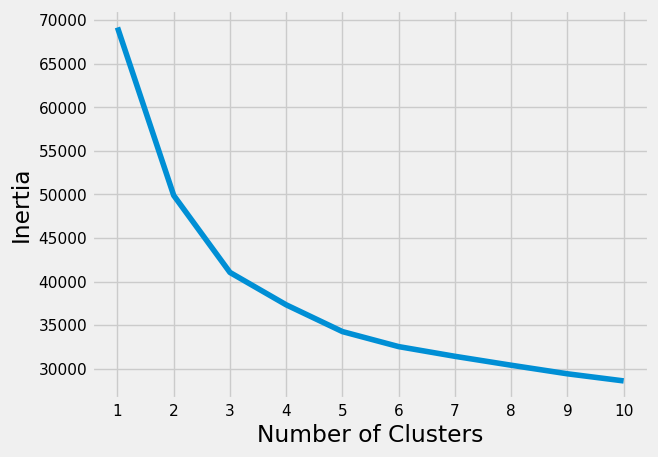

In [44]:
# Visualización de resultados
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [45]:
# Lista contiene los coeficientes de silueta para cada k
silhouette_coefficients = []
# Fíjate que empiezas con 2 grupos para el coeficiente de silueta
for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(scaled1)
  score = silhouette_score(scaled1, kmeans.labels_)
  silhouette_coefficients.append(score)

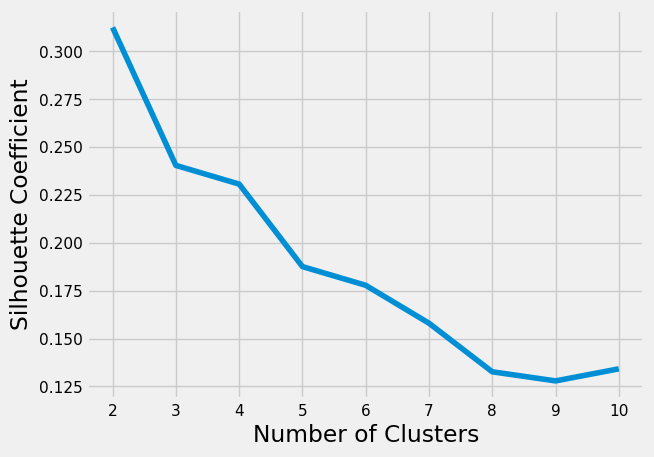

In [46]:
# Visualización de resultados
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### Dendograma

In [62]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Función de vinculación para agrupar datos según similud
Z = linkage(scaled1, method='ward')
Z[:5]

array([[4.83000000e+02, 4.85000000e+02, 0.00000000e+00, 2.00000000e+00],
       [4.17300000e+03, 4.17800000e+03, 0.00000000e+00, 2.00000000e+00],
       [4.25900000e+03, 4.26000000e+03, 0.00000000e+00, 2.00000000e+00],
       [9.18000000e+02, 9.20000000e+02, 0.00000000e+00, 2.00000000e+00],
       [1.28400000e+03, 1.28500000e+03, 1.40598734e-02, 2.00000000e+00]])

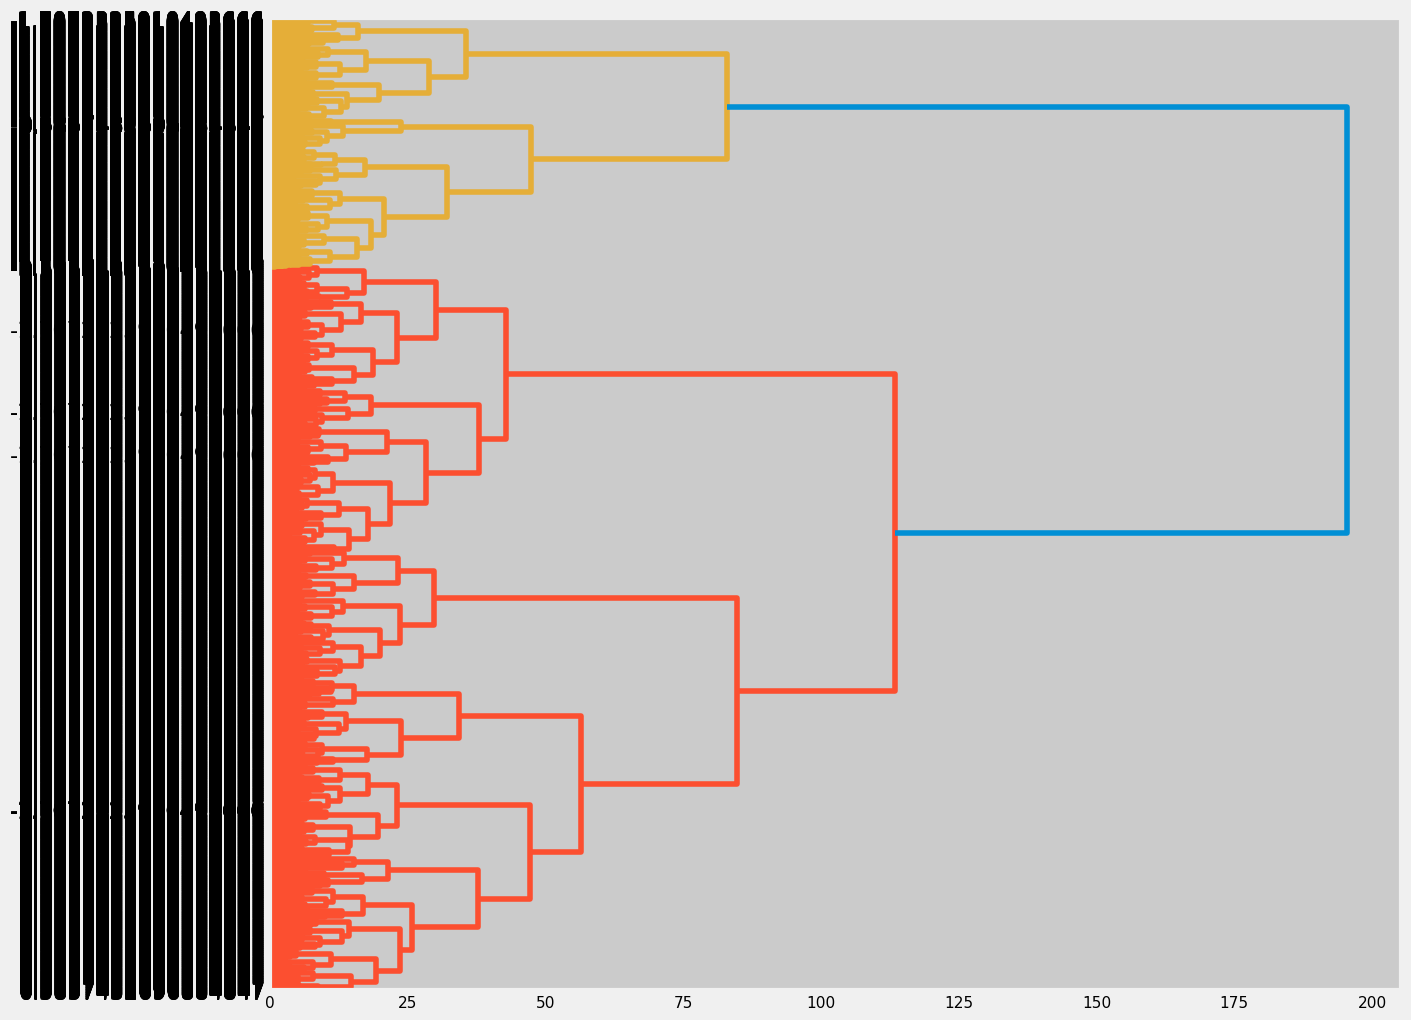

In [64]:
# Dibujo del dendograma
labelList = list(scaled1['color'])

plt.figure(figsize=(13, 12))
dendrogram(
    Z,
    orientation='right',
    labels=labelList,
    distance_sort='descending',
    show_leaf_counts=False,
    leaf_font_size=16
)
plt.show()

# Hierarchical Clustering

In [104]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters = 5, metric = 'euclidean', linkage = 'ward')

y_hc = hc.fit_predict(scaled1)

print(hc.labels_)

[1 1 1 ... 0 2 2]


In [105]:
scaled1['cluster'] = y_hc
display(scaled1.head(5))
display(scaled1.tail(5))

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0       0.238055          2.298926    -2.273272       -0.724004   1.019157   
1       0.605077          2.298926    -2.273272       -0.559650   2.020762   
2       0.605077          2.298926    -1.985367       -0.630087   1.747597   
3       2.302554         -0.386644     1.757397       -0.724004   0.973630   
4       0.238055          2.164647    -2.273272       -0.747483   0.973630   

   free_sulfur_dioxide  total_sulfur_dioxide   density        pH  sulphates  \
0            -1.114479             -1.417952  1.128801  1.812423   0.240980   
1            -0.287116             -0.833163  0.783878 -0.151665   1.156786   
2            -0.878090             -1.063534  0.852863  0.228481   0.927835   
3            -0.759895             -0.957209  1.197786 -0.405096   0.393614   
4            -0.996285             -1.311627  1.128801  1.812423   0.240980   

    alcohol   quality     color  cluster  
0 -0.969388 -0.937379 -1.707233        1  
1 -0.631951 -0.937379 -1.707233        1  
2 -0.631951 -0.937379 -1.707233        1  
3 -0.631951  0.259515 -1.707233        4  
4 -0.969388 -0.937379 -1.707233        1

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
5315      -0.863010         -0.856618    -0.185961       -0.794441  -0.665360   
5316      -0.495988         -0.118087     0.317872        0.708221  -0.301140   
5317      -0.587744         -0.655201    -0.905723       -0.888357  -0.574305   
5318      -1.505299         -0.319505    -0.113985       -0.911836  -1.439328   
5319      -1.046521         -0.856618     0.461825       -0.982274  -1.530383   

      free_sulfur_dioxide  total_sulfur_dioxide   density        pH  \
5315            -0.346214             -0.390140 -1.168389  0.291838   
5316             1.603998              0.956648  0.128523 -0.468454   
5317             0.008370             -0.053443 -0.685496 -1.482177   
5318            -0.582603             -0.071164 -2.013452  0.735342   
5319            -0.464408             -0.283815 -1.765107  0.228481   

      sulphates   alcohol   quality     color  cluster  
5315  -0.216923  0.549078  0.259515  0.585743        2  
5316  -0.522192 -0.800670 -0.937379  0.585743        0  
5317  -0.522192 -0.969388  0.259515  0.585743        0  
5318  -1.132729  1.898826  1.456408  0.585743        2  
5319  -1.590632  1.055234  0.259515  0.585743        2

In [106]:
scaled1.describe()

fixed_acidity  volatile_acidity   citric_acid  residual_sugar  \
count   5.320000e+03      5.320000e+03  5.320000e+03    5.320000e+03   
mean   -8.547883e-17      8.547883e-17 -8.547883e-17   -2.136971e-16   
std     1.000094e+00      1.000094e+00  1.000094e+00    1.000094e+00   
min    -2.468731e+00     -1.729429e+00 -2.273272e+00   -1.029232e+00   
25%    -6.794994e-01     -7.223400e-01 -5.458422e-01   -7.474828e-01   
50%    -1.289665e-01     -2.523653e-01 -4.200868e-02   -5.361709e-01   
75%     5.133219e-01      4.861664e-01  6.057773e-01    5.908260e-01   
max     2.302554e+00      2.298926e+00  2.333207e+00    2.598289e+00   

          chlorides  free_sulfur_dioxide  total_sulfur_dioxide       density  \
count  5.320000e+03          5320.000000          5.320000e+03  5.320000e+03   
mean   3.419153e-16             0.000000          2.136971e-17  2.842171e-15   
std    1.000094e+00             1.000094          1.000094e+00  1.000094e+00   
min   -2.031186e+00            -1.705453         -1.914137e+00 -2.558431e+00   
25%   -7.108880e-01            -0.818992         -7.091163e-01 -8.027702e-01   
50%   -3.011405e-01            -0.109824          3.516115e-02  4.229235e-02   
75%    5.638821e-01             0.658441          6.952644e-01  7.735301e-01   
max    2.476037e+00             2.874591          2.801836e+00  3.137981e+00   

                 pH     sulphates       alcohol       quality         color  \
count  5.320000e+03  5.320000e+03  5.320000e+03  5.320000e+03  5.320000e+03   
mean   1.132594e-15 -2.778062e-16 -1.431770e-15 -4.434214e-16 -2.136971e-16   
std    1.000094e+00  1.000094e+00  1.000094e+00  1.000094e+00  1.000094e+00   
min   -2.812689e+00 -2.353804e+00 -2.150417e+00 -2.732720e+00 -1.707233e+00   
25%   -7.218847e-01 -7.511432e-01 -8.850289e-01 -9.373794e-01 -1.707233e+00   
50%   -8.830777e-02 -1.406058e-01 -1.257957e-01  2.595145e-01  5.857433e-01   
75%    6.719846e-01  5.462488e-01  7.177967e-01  2.595145e-01  5.857433e-01   
max    2.762789e+00  2.492337e+00  3.122035e+00  2.054855e+00  5.857433e-01   

           cluster  
count  5320.000000  
mean      1.550752  
std       1.332931  
min       0.000000  
25%       0.000000  
50%       2.000000  
75%       2.000000  
max       4.000000